# Mini-Project for Fundamentals of Machine Learning Course
In this study, facial expression recognition was performed on the face images from the Facial Expression Recognition Challenge (FER2013) dataset.

One motivation for representation learning is that learning algorithms can design features more effectively and efficiently than humans can. However, this challenge does not explicitly require entries to use representation learning. The dataset, assembled from the internet, is designed for facial expression classification.

The data consists of grayscale images of faces, each measuring 48x48 pixels. The faces have been automatically aligned to be roughly centered and occupy a similar area within each image. The task is to categorize each face based on the emotion expressed, assigning it to one of seven categories (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral). The dataset contains a total of 35,887 examples.

## 1. Prerequisite
This section provides some basic steps for accessing and visualizing the dataset.

In [3]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [4]:
def parse_data(data: pd.DataFrame):
    """
    Reads input dataframe then return arrays of images and labels
    """
    image_array = np.zeros(shape=(len(data), 48, 48))
    image_raw_array = np.zeros(shape=(len(data), 2304))
    image_label = np.array(list(map(int, data['emotion'])))
    
    for i, row in enumerate(data.index):
        image_raw = np.fromstring(data.loc[row, 'pixels'], dtype=int, sep=' ')
        image = np.reshape(image_raw, (48, 48))
        image_array[i] = image
        image_raw_array[i] = image_raw
        
    return image_raw_array, image_array, image_label

In [5]:
def show_img(images: np.ndarray, labels: np.ndarray):
    """
    Visualize images and labels respectively
    """
    _, axarr=plt.subplots(nrows=2, ncols=5, figsize=(18, 9))
    axarr=axarr.flatten()
    for idx, label in enumerate(labels[:10]):
        axarr[idx].imshow(images[idx], cmap='gray')
        axarr[idx].set_xticks([])
        axarr[idx].set_yticks([])
        axarr[idx].set_title("Label:{}".format(label))

### EDA

In [6]:
## load dataset here
df = pd.read_csv("/kaggle/input/icml-face-data/icml_face_data.csv")
df.head()

,emotion,pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


The ```emotion``` column contains a numeric code ranging from 0 to 6, inclusive, for the emotion expressed by the image. The "pixels" column contains a string surrounded in quotes for each image.

In [7]:
# check missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35887 entries, 0 to 35886
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  35887 non-null  int64 
 1   pixels   35887 non-null  object
dtypes: int64(1), object(1)
memory usage: 560.9+ KB


Dữ liệu đã cho không có giá trị thiếu

In [8]:
# check and drop duplicate values 
df.duplicated().value_counts()
df.drop_duplicates(inplace=True)

In [9]:
df['emotion'].value_counts()

emotion
3    8800
6    6057
4    5934
2    4835
0    4740
5    3267
1     461
Name: count, dtype: int64

Có sự chênh lệnh rất lớn giữa số lượng lable 1 với các lable khác từ 10-20 lần

### Parsing data

In [10]:
## parsing data here
image_raws, images, labels = parse_data(df)

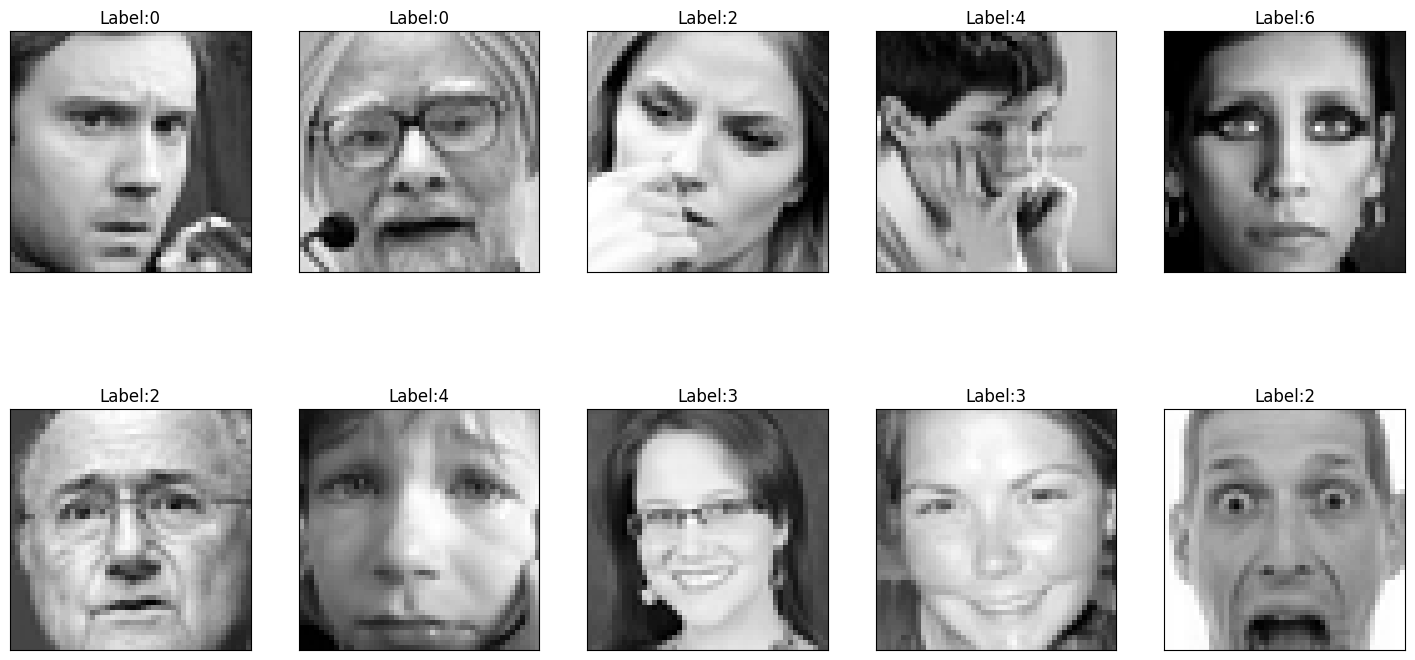

In [11]:
## showing images here
show_img(images, labels)

## 2. Principle Component Analysis

Unsupervised learning can be further categorized into two main tasks: data transformation and clustering. In this study, we will focus on data transformation using unsupervised learning techniques. These techniques aim to modify the data to make it easier for computers and humans to analyze and understand.

One of the most common applications of unsupervised data transformation is dimensionality reduction. This process reduces the number of features (dimensions) in the data. When the data has a high number of features, it can be computationally expensive and difficult to analyze. Dimensionality reduction techniques help to overcome these challenges.

Principal Component Analysis (PCA) is a popular technique for dimensionality reduction. It transforms the data into a new set of features called principal components (PCs). These PCs are ordered by their importance, capturing the most significant variations in the data. By selecting a subset of the most informative PCs, we can achieve a significant reduction in data size while preserving the essential information for analysis.

### PCA

### Question 1: Can you visualize the data projected onto two principal components? (2 points)

In [59]:
# check data shape
image_raws.shape

(34094, 2304)

Thực hiện PCA trên ma trận 2 chiều image_raws với 35887 dòng tương ứng với 35887 dữ liệu ảnh, 2304 cột tương ứng với giá trị 48x48 pixel khi được reshape thành mảng 1 chiều

In [60]:
# normalize data images
import tensorflow as tf 
norm_images = tf.keras.utils.normalize(image_raws)

In [61]:
from sklearn.decomposition import PCA
pca=PCA(n_components=2)
pca.fit(norm_images) 

PCA(n_components=2)

In [62]:
## transform for visualizing here
images_pca=pca.transform(norm_images) ## modify images' array to the appropriate shape
images_pca.shape

(34094, 2)

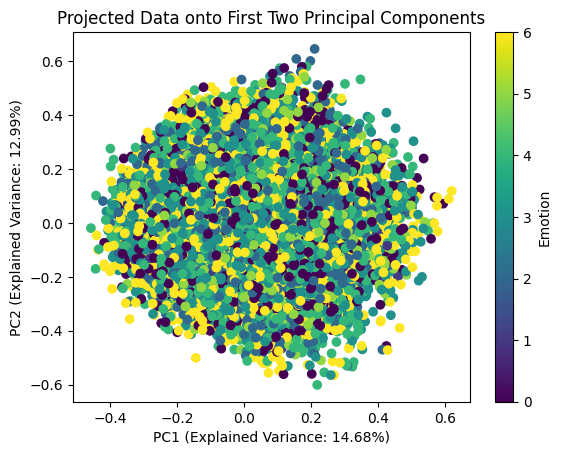

In [63]:
principal_components = pca.components_
projected_data = norm_images.dot(principal_components.T)

import matplotlib.pyplot as plt

# Scatter plot of projected data
scatter = plt.scatter(projected_data[:, 0], projected_data[:, 1], c=labels, cmap="viridis")
cbar = plt.colorbar(scatter, ticks = range(len(np.unique(labels))), label="Emotion")

# Label axes based on explained variance ratio (optional)
plt.xlabel("PC1 (Explained Variance: {:.2f}%)".format(pca.explained_variance_ratio_[0] * 100))
plt.ylabel("PC2 (Explained Variance: {:.2f}%)".format(pca.explained_variance_ratio_[1] * 100))

plt.title("Projected Data onto First Two Principal Components")
plt.show()

In [64]:
pca.explained_variance_ratio_.sum()

0.27665290359443273

Sau khi giảm số chiều của tập dữ liệu bằng PCA với n_components = 2, ta giữ lại được khoảng 27.66% thông tin (về phương sai) từ tập dữ liệu gốc. Đây có thể được xem là thấp, điều đó gợi ý rằng ta cần một số lượng lớn hơn các thành phần chính để nắm bắt nhiều phương sai hơn hoặc tập dữ liệu có tính đa chiều cao 

### Question 2: How to determine the optimal number of principal components using ```pca.explained_variance_```? Explain your selection process. (2 points)

Xác định số lượng thành phần chính tối ưu (PCs) trong Phân tích thành phần chính (PCA) là một bước quan trọng để giảm chiều dữ liệu hiệu quả. Việc lựa chọn số lượng PCs phù hợp giúp cân bằng giữa việc giữ lại thông tin quan trọng nhất từ dữ liệu gốc và giảm thiểu nhiễu và đa dư.

Phương pháp phổ biến để xác định số lượng PCs tối ưu là sử dụng kết hợp phân tích trực quan và định lượng dựa trên biến explained_variance_ của PCA. Dưới đây là các bước thực hiện:

- Step 1: Fit PCA model

In [65]:
pca = PCA()
pca.fit(norm_images)

PCA()

- Step 2: Explained variance ratio

In [66]:
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = pca.explained_variance_ratio_.cumsum()

- Step 3: Create a scree plot to visualize the explained variance

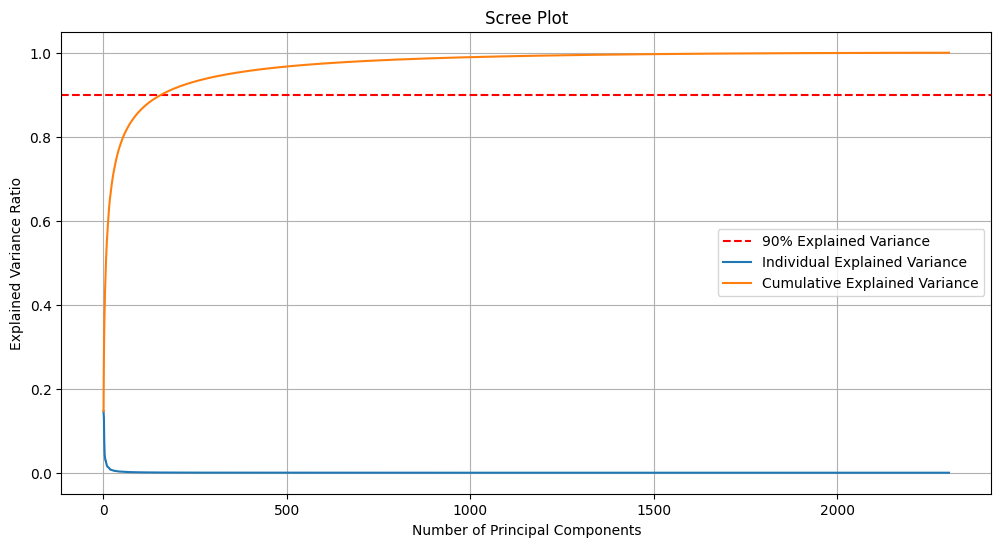

In [67]:
plt.figure(figsize=(12, 6))
plt.axhline(y=0.9, color='r', linestyle='--', label='90% Explained Variance')
# plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o', label='Individual Explained Variance')
# plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='x', label='Cumulative Explained Variance')
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, label='Individual Explained Variance')
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, label='Cumulative Explained Variance')

plt.xlabel('Number of Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot')
plt.legend()
plt.grid(True)
plt.show()



- Step 4: Determine the "Elbow" Point

Dựa vào biểu đồ Scree Plot, điểm khuỷu tay có thể nằm ở khoảng 150-175 PCs, tương ứng với 90% thông tin về phương sai của dữ liệu gốc. Do đó, lựa chọn 150-175 PCs có thể là số lượng thành phần chính tối ưu cho trường hợp này.

- Step 5: Threshold Method  

In [68]:
# Optimal number of components based on explained variance threshold (e.g., 90%)
optimal_components = next(i for i, total_var in enumerate(cumulative_explained_variance) if total_var >= 0.9) + 1
print(f'Optimal number of components: {optimal_components}')

Optimal number of components: 158


Một cách khác để tìm được số thành phần chính là dùng phương pháp threshold. Đặt ngưỡng phương sai tích luỹ là 90%, ta tìm được số lượng thành phần chính tối ưu là 158

**Selection Process Explained**

1. Scree Plot and "Elbow" Method: The scree plot shows the explained variance of each principal component. The "elbow" point, where the explained variance curve starts to flatten, indicates diminishing returns for adding more components. This point is chosen as the optimal number of components because it captures most of the variance while avoiding unnecessary complexity.
2. Cumulative Variance Threshold: This method sets a threshold for the cumulative explained variance (e.g., 80% or 90%). The optimal number of components is the smallest number that meets or exceeds this threshold, ensuring that a sufficient amount of variance is captured.  

By using both the scree plot and the cumulative variance threshold, can make a well-informed decision on the optimal number of principal components for your analysis.

## 3. Image Classification

The classification task will compare the performance using both:

- Original data: The data before applying PCA.
- Transformed data: The data projected onto the optimal number of principal components identified earlier. Utilize the **optimal number of principal components** identified in the previous question.

Compare the performance of **4** different classification algorithms (3 machine learning and 1 MLP models) in both formats above. (4 points)

Perform hyperparameter tuning using ```GridSearchCV``` for each classification method. (1 point)

Inspiration: Draw inspiration from the example provided in the scikit-learn documentation: https://scikit-learn.org/dev/auto_examples/datasets/plot_iris_dataset.html

Load modules

In [12]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report

### PCA with 158 principal components

In [13]:
pca = PCA(n_components=158)
images_pca = pca.fit_transform(image_raws)
images_pca.shape

(34094, 158)

### Split data

In [16]:
### split data into train/val/test subsets here
from sklearn.model_selection import train_test_split

def split_data(X, y):
    train_ratio = 0.75
    validation_ratio = 0.15
    test_ratio = 0.10

    # train is now 75% of the entire data set
    x_train, x_test, y_train, y_test = train_test_split(X, y, train_size=train_ratio, random_state=101)

    # test is now 10% of the initial data set
    # validation is now 15% of the initial data set
    x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio), random_state=101) 
    return (x_train, x_test, x_val, y_train, y_test, y_val)


In [17]:
x_train_norm, x_test_norm, x_val_norm, y_train_norm, y_test_norm, y_val_norm = split_data(image_raws, labels)
print("On the original normalized data set")
print(f"- training set shape: {x_train_norm.shape}")
print(f"- testing set shape: {x_test_norm.shape}")
print(f"- valid set shape: {x_val_norm.shape}")

On the original normalized data set
- training set shape: (25570, 2304)
- testing set shape: (3410, 2304)
- valid set shape: (5114, 2304)


In [18]:
x_train_pca, x_test_pca, x_val_pca, y_train_pca, y_test_pca, y_val_pca = split_data(images_pca, labels)
print("On the transformed data set")
print(f"- training set shape: {x_train_pca.shape}")
print(f"- testing set shape: {x_test_pca.shape}")
print(f"- valid set shape: {x_val_pca.shape}")

On the transformed data set
- training set shape: (25570, 158)
- testing set shape: (3410, 158)
- valid set shape: (5114, 158)


### Building models

#### 1. Model 1: RandomForestClassifier()

- On original dataset

In [82]:
x_train_norm.shape

(25570, 2304)

In [108]:
# Define RandomForestClassifier
rfc = RandomForestClassifier(random_state=42)

# Define the pipeline with a scaler and RandomForestClassifier
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Preprocessing step
    ('classifier', rfc)
])

# Define the parameter grid for GridSearchCV
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [None, 10, 15],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__criterion' :['gini', 'entropy']
}

# Define GridSearchCV
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)


In [109]:
# Fitting
grid_search.fit(x_train_norm, y_train_norm)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


/opt/conda/lib/python3.10/site-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


[CV] END classifier__max_depth=None, classifier__n_estimators=100; total time= 1.8min
[CV] END classifier__max_depth=None, classifier__n_estimators=200; total time= 3.7min
[CV] END classifier__max_depth=None, classifier__n_estimators=200; total time= 3.7min
[CV] END classifier__max_depth=10, classifier__n_estimators=200; total time= 2.3min
[CV] END classifier__max_depth=15, classifier__n_estimators=100; total time= 1.7min
[CV] END classifier__max_depth=15, classifier__n_estimators=200; total time= 3.4min
[CV] END classifier__max_depth=None, classifier__n_estimators=100; total time= 1.9min
[CV] END classifier__max_depth=None, classifier__n_estimators=200; total time= 3.7min
[CV] END classifier__max_depth=10, classifier__n_estimators=100; total time= 1.2min
[CV] END classifier__max_depth=10, classifier__n_estimators=100; total time= 1.2min
[CV] END classifier__max_depth=10, classifier__n_estimators=200; total time= 2.3min
[CV] END classifier__max_depth=15, classifier__n_estimators=100; t

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('classifier',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__max_depth': [None, 10, 15],
                         'classifier__n_estimators': [100, 200]},
             verbose=2)

[CV] END classifier__max_depth=None, classifier__n_estimators=100; total time= 1.8min
[CV] END classifier__max_depth=None, classifier__n_estimators=200; total time= 3.7min
[CV] END classifier__max_depth=10, classifier__n_estimators=100; total time= 1.2min
[CV] END classifier__max_depth=10, classifier__n_estimators=100; total time= 1.2min
[CV] END classifier__max_depth=10, classifier__n_estimators=200; total time= 2.3min
[CV] END classifier__max_depth=10, classifier__n_estimators=200; total time= 2.4min
[CV] END classifier__max_depth=15, classifier__n_estimators=100; total time= 1.7min
[CV] END classifier__max_depth=15, classifier__n_estimators=200; total time= 3.2min


In [110]:
# Print the best parameters and best score
print(f"Best parameters found: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_}")

# Predict on the validation set
y_val_pred = grid_search.predict(x_val_norm)

# Evaluate the model
val_accuracy = accuracy_score(y_val_norm, y_val_pred)
print(f"Validation Accuracy: {val_accuracy}")
print("Validation Classification Report:")
print(classification_report(y_val_norm, y_val_pred))

# Predict on the test set
y_test_pred = grid_search.predict(x_test_norm)

# Evaluate the model
test_accuracy = accuracy_score(y_test_norm, y_test_pred)
print(f"Test Accuracy: {test_accuracy}")
print("Test Classification Report:")
print(classification_report(y_test_norm, y_test_pred))

Best parameters found: {'classifier__max_depth': None, 'classifier__n_estimators': 200}
Best cross-validation score: 0.42061008994915916
Validation Accuracy: 0.4192412983965585
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.41      0.12      0.19       706
           1       1.00      0.04      0.07        56
           2       0.39      0.21      0.28       721
           3       0.42      0.79      0.55      1302
           4       0.35      0.34      0.34       910
           5       0.59      0.43      0.49       494
           6       0.42      0.38      0.40       925

    accuracy                           0.42      5114
   macro avg       0.51      0.33      0.33      5114
weighted avg       0.43      0.42      0.39      5114

Test Accuracy: 0.41642228739002934
Test Classification Report:
              precision    recall  f1-score   support

           0       0.43      0.12      0.19       485
           1       0

In [113]:
#saving the  model to be used later
import pickle
pickle.dump(grid_search, open(file = "/kaggle/working/md_rfc_norm.sav", mode = "wb"))


- On transformed dataset

In [29]:
# Define RandomForestClassifier
rfc = RandomForestClassifier(random_state=42)

# Define the pipeline with a scaler and RandomForestClassifier
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Preprocessing step
    ('classifier', rfc)
])

# Define the parameter grid for GridSearchCV
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [None, 10, 15],
#     'classifier__min_samples_split': [2, 5, 10],
    'classifier__criterion' :['gini', 'entropy']
}

# param_grid = { 
#     'n_estimators': [200, 500],
#     'max_features': ['auto', 'sqrt', 'log2'],
#     'max_depth' : [4,5,6,7,8]
#     'criterion' :['gini', 'entropy', 'log_loss']
# }

# Define GridSearchCV
grid_search_pca = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# Fitting
grid_search_pca.fit(x_train_pca, y_train_pca)


Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('classifier',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__criterion': ['gini', 'entropy'],
                         'classifier__max_depth': [None, 10, 15],
                         'classifier__n_estimators': [100, 200]},
             verbose=2)

[CV] END classifier__criterion=gini, classifier__max_depth=None, classifier__n_estimators=100; total time=  44.0s
[CV] END classifier__criterion=gini, classifier__max_depth=None, classifier__n_estimators=100; total time=  44.3s
[CV] END classifier__criterion=gini, classifier__max_depth=None, classifier__n_estimators=200; total time= 1.5min
[CV] END classifier__criterion=gini, classifier__max_depth=10, classifier__n_estimators=100; total time=  29.1s
[CV] END classifier__criterion=gini, classifier__max_depth=10, classifier__n_estimators=200; total time=  56.9s
[CV] END classifier__criterion=gini, classifier__max_depth=15, classifier__n_estimators=100; total time=  38.3s
[CV] END classifier__criterion=gini, classifier__max_depth=15, classifier__n_estimators=100; total time=  37.7s
[CV] END classifier__criterion=gini, classifier__max_depth=15, classifier__n_estimators=200; total time= 1.3min
[CV] END classifier__criterion=entropy, classifier__max_depth=None, classifier__n_estimators=100; 

In [30]:
# Print the best parameters and best score
print(f"Best parameters found: {grid_search_pca.best_params_}")
print(f"Best cross-validation score: {grid_search_pca.best_score_}")

# Predict on the validation set
y_val_pred = grid_search_pca.predict(x_val_pca)

# Evaluate the model
val_accuracy = accuracy_score(y_val_pca, y_val_pred)
print(f"Validation Accuracy: {val_accuracy}")
print("Validation Classification Report:")
print(classification_report(y_val_pca, y_val_pred))

# Predict on the test set
y_test_pred = grid_search_pca.predict(x_test_pca)

# Evaluate the model
test_accuracy = accuracy_score(y_test_pca, y_test_pred)
print(f"Test Accuracy: {test_accuracy}")
print("Test Classification Report:")
print(classification_report(y_test_pca, y_test_pred))

Best parameters found: {'classifier__criterion': 'gini', 'classifier__max_depth': None, 'classifier__n_estimators': 200}
Best cross-validation score: 0.3674618693781776
Validation Accuracy: 0.3597966366836136
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.45      0.08      0.14       706
           1       1.00      0.02      0.04        56
           2       0.42      0.16      0.23       721
           3       0.34      0.84      0.48      1302
           4       0.33      0.23      0.27       910
           5       0.66      0.26      0.38       494
           6       0.38      0.25      0.30       925

    accuracy                           0.36      5114
   macro avg       0.51      0.26      0.26      5114
weighted avg       0.41      0.36      0.31      5114

Test Accuracy: 0.35953079178885633
Test Classification Report:
              precision    recall  f1-score   support

           0       0.42      0.07      0.1

In [34]:
#saving the  model to be used later
import pickle
pickle.dump(grid_search_pca, open(file = "/kaggle/working/md_rfc_pca.sav", mode = "wb"))


In [ ]:
# images_pca=pca.transform(images) ## modify images' array to the appropriate shape 12:47

## 4. Evaluating Classification Performance

Compare the performance of the different classification models using various metrics: accuracy, precision, recall, and F1-score.
Based on the evaluation metrics, explain which model performs best and why. Identify the emotion category where the model makes the most accurate and most errors. (1 point)



In [ ]:
## visualize the confusion matrices and classification reports here